In [1]:
import os
import cv2
import torch
import random
import numpy as np
img_root = '/opt/ml/data/images/train'
label_root = '/opt/ml/data/labels/train'
imgs = os.listdir(img_root)[:4]
label_files = []
for img in imgs:
    label_files.append(os.path.splitext(img)[0] + '.txt')

In [2]:

labels = []
for label_file in label_files:
    with open(os.path.join(label_root, label_file)) as f:
        label = f.readlines()
    tmp = []
    for lbl in label:
        tmp2 = []
        for idx, val in enumerate(lbl.rstrip().split()):
            if not idx:
                tmp2.append(int(val))
            else:
                tmp2.append(float(val))
        tmp.append(tmp2)
    labels.append(tmp)
labels = np.array(labels)
print(labels)

[[[0.       0.524216 0.468635 0.684963 0.630996]
  [1.       0.543589 0.426199 0.35286  0.250923]]

 [[0.       0.480958 0.440418 0.706388 0.460688]
  [1.       0.487715 0.47973  0.899263 0.691646]]

 [[0.       0.504902 0.502941 0.990196 0.856863]
  [1.       0.468627 0.517647 0.878431 0.666667]]

 [[0.       0.481242 0.494465 0.962485 0.653137]
  [1.       0.48278  0.493542 0.733087 0.370849]]]


In [3]:
def load_image(i):
    # loads 1 image from dataset index 'i', returns im, original hw, resized hw
    im = imgs[i]
    img_path = os.path.join(img_root, im)
    im = cv2.imread(img_path)
    h0, w0 = im.shape[:2]
    return im, (h0, w0), im.shape[:2]  # im, hw_original, hw_resized


In [4]:

def load_mosaic():
    # YOLOv5 4-mosaic loader. Loads 1 image + 3 random images into a 4-image mosaic
    labels4 = []
    s = 512
    # print('img_size: ', str(s*2), str(s*2))
    yc, xc = [int(random.uniform(1.0, 1.0)) * s, int(random.uniform(1.0, 1.0)) * s]  # mosaic center x, y
    # print('center location: ', yc, xc)
    indices = [0, 1, 2, 3]  # 3 additional image indices
    random.shuffle(indices)
    for i, index in enumerate(indices):
        # Load image
        img, _, (h, w) = load_image(index)
        img = cv2.resize(img, (s, s))
        # print(img.shape)
        # place img in img4
        if i == 0:  # top left
            img4 = np.full((s * 2, s * 2, img.shape[2]), 114, dtype=np.uint8)  # base image with 4 tiles
            x1a, y1a, x2a, y2a = 0, 0, xc, yc  # xmin, ymin, xmax, ymax (large image)
            # x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h  # xmin, ymin, xmax, ymax (small image)
        elif i == 1:  # top right
            x1a, y1a, x2a, y2a = xc, 0, s * 2, yc
            # x1b, y1b, x2b, y2b = 0, h - (y2a - y1a), min(w, x2a - x1a), h
        elif i == 2:  # bottom left
            x1a, y1a, x2a, y2a = 0, yc, xc, s * 2
            # x1b, y1b, x2b, y2b = w - (x2a - x1a), 0, w, min(y2a - y1a, h)
        elif i == 3:  # bottom right
            x1a, y1a, x2a, y2a = xc, yc, s * 2, s * 2
            # x1b, y1b, x2b, y2b = 0, 0, min(w, x2a - x1a), min(y2a - y1a, h)

        img4[y1a:y2a, x1a:x2a] = img[:, :]  # img4[ymin:ymax, xmin:xmax]
        padw = x1a
        padh = y1a

        # Labels
        labels2 = labels[index].copy()
        if labels2.size:
            print(w, h)
            labels2[:, 1:] = xywhn2xyxy(labels2[:, 1:], w, h, padw, padh, s)  # normalized xywh to pixel xyxy format

        labels4.append(labels2)

    # Concat/clip labels
    labels4 = np.concatenate(labels4, 0)

    np.clip(labels4[:, 1:], 0, 2 * s, out=labels4[:, 1:])  # clip when using random_perspective()
    # img4, labels4 = replicate(img4, labels4)  # replicate
    print('labels4', labels4)
    # # Augment
    # img4, labels4, segments4 = copy_paste(img4, labels4, None, p=self.hyp['copy_paste'])
    # img4, labels4 = random_perspective(img4, labels4, segments4,
    #                                    degrees=self.hyp['degrees'],
    #                                    translate=self.hyp['translate'],
    #                                    scale=self.hyp['scale'],
    #                                    shear=self.hyp['shear'],
    #                                    perspective=self.hyp['perspective'],
    #                                    border=self.mosaic_border)  # border to remove

    return img4, labels4

In [5]:
def xywhn2xyxy(x, w=640, h=640, padw=0, padh=0, scale=1.):
    # Convert nx4 boxes from [x, y, w, h] normalized to [x1, y1, x2, y2] where xy1=top-left, xy2=bottom-right
    y = x.clone() if isinstance(x, torch.Tensor) else np.copy(x)
    y[:, 0] = (scale * (x[:, 0] - x[:, 2] / 2) + padw)
    y[:, 1] = (scale * (x[:, 1] - x[:, 3] / 2) + padh)
    y[:, 2] = (scale * (x[:, 0] + x[:, 2] / 2) + padw)
    y[:, 3] = (scale * (x[:, 1] + x[:, 3] / 2) + padh)
    return y

In [6]:
def save_one_box(xyxy, im, file='image.jpg', gain=1.02, pad=10, square=False, BGR=False, save=True):
    # Save image crop as {file} with crop size multiple {gain} and {pad} pixels. Save and/or return crop
    xyxy = torch.tensor(xyxy).view(-1, 4)
    b = xyxy2xywh(xyxy)  # boxes
    if square:
        b[:, 2:] = b[:, 2:].max(1)[0].unsqueeze(1)  # attempt rectangle to square
    b[:, 2:] = b[:, 2:] * gain + pad  # box wh * gain + pad
    xyxy = xywh2xyxy(b).long()
    clip_coords(xyxy, im.shape)
    crop = im[int(xyxy[0, 1]):int(xyxy[0, 3]), int(xyxy[0, 0]):int(xyxy[0, 2]), ::(1 if BGR else -1)]
    if save:
        cv2.imwrite(str(increment_path(file, mkdir=True).with_suffix('.jpg')), crop)
    return crop

In [7]:
img, labels = load_mosaic()

828 828
1920 1920
3024 4032
4032 3024
labels4 [[0.00000000e+00 6.54151680e+01 1.07557888e+02 4.27085824e+02
  3.43430144e+02]
 [1.00000000e+00 1.94987520e+01 6.85603840e+01 4.79921408e+02
  4.22683136e+02]
 [0.00000000e+00 5.17019648e+02 3.81488640e+01 1.02400000e+03
  4.76862720e+02]
 [1.00000000e+00 5.27058688e+02 9.43685120e+01 9.76815360e+02
  4.35702016e+02]
 [0.00000000e+00 0.00000000e+00 5.97963008e+02 4.92792064e+02
  9.32369152e+02]
 [1.00000000e+00 5.95130880e+01 6.69756160e+02 4.34853632e+02
  8.59630848e+02]
 [0.00000000e+00 6.05048064e+02 5.90406144e+02 9.55749120e+02
  9.13476096e+02]
 [1.00000000e+00 6.99985408e+02 6.65977600e+02 8.80649728e+02
  7.94450176e+02]]


In [8]:
from PIL import ImageDraw
def pil_draw_rect(image, point1, point2):
    draw = ImageDraw.Draw(image)
    draw.rectangle((point1, point2), outline=(0, 0, 255), width=3)
    return image

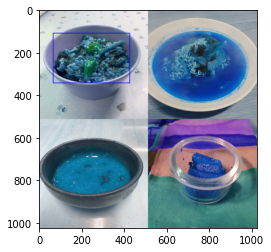

In [9]:
import matplotlib.pyplot as plt
from PIL import Image
x1, y1 = labels[0][1:3]
x2, y2 = labels[0][3:5]
img = Image.fromarray(img)
img = pil_draw_rect(img, (x1, y1), (x2, y2))
plt.imshow(np.array(img))